In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv("Facebook.csv")[["Open", "High", "Low", "Close", "Volume", "Adj Close", "Date"]]
df["Close"] = df["Close"].astype(np.int64)
date2017 = datetime(2017, 1, 1)
date2019 = datetime(2019, 1, 1)

df = df.assign(
    before2017 = pd.Series(data = [int(datetime.strptime(date, '%Y-%m-%d') < date2017) for date in df.Date]) ,
    between2017and2019 = pd.Series(data = [int((datetime.strptime(date, '%Y-%m-%d') > date2017) & (datetime.strptime(date, '%Y-%m-%d') <= date2019)) for date in df.Date]),
    after2019 = pd.Series(data = [int((datetime.strptime(date, '%Y-%m-%d') > date2019)) for date in df.Date]),
)
df

,Open,High,Low,Close,Volume,Adj Close,Date,before2017,between2017and2019,after2019
0,113.320000,114.589996,112.949997,113,21351800,113.690002,2016-03-28,1,0,0
1,113.830002,116.320000,113.639999,116,29825300,116.139999,2016-03-29,1,0,0
2,116.730003,116.989998,114.360001,114,33235200,114.699997,2016-03-30,1,0,0
3,114.699997,115.010002,113.769997,114,21207500,114.099998,2016-03-31,1,0,0
4,113.750000,116.169998,113.349998,116,24760500,116.059998,2016-04-01,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1255,290.450012,299.709991,286.750000,293,28273100,293.540009,2021-03-22,0,0,1
1256,293.149994,298.000000,289.809998,290,23000900,290.630005,2021-03-23,0,0,1
1257,291.000000,291.720001,281.160004,282,18675000,282.140015,2021-03-24,0,0,1
1258,280.980011,288.059998,277.750000,278,24505600,278.739990,2021-03-25,0,0,1


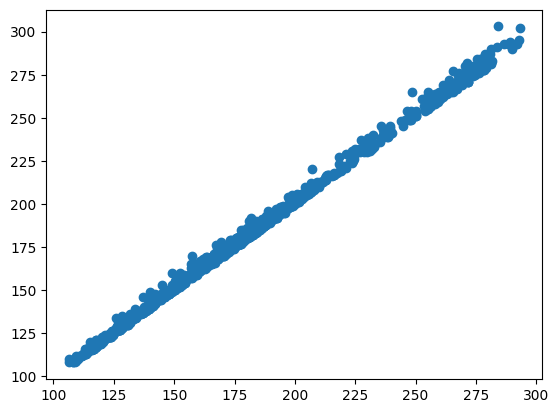

In [2]:
import matplotlib.pyplot as plt

plt.scatter(df["Low"], df["Close"])

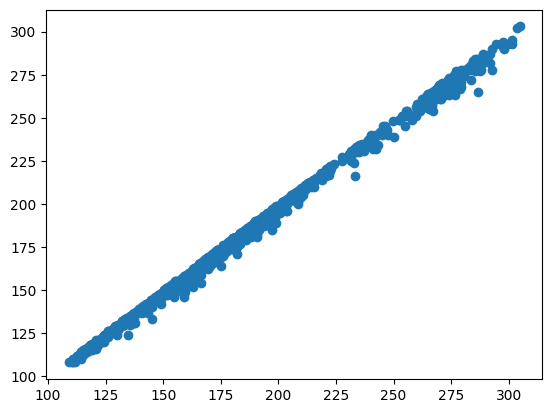

In [3]:
plt.scatter(df["High"], df["Close"])

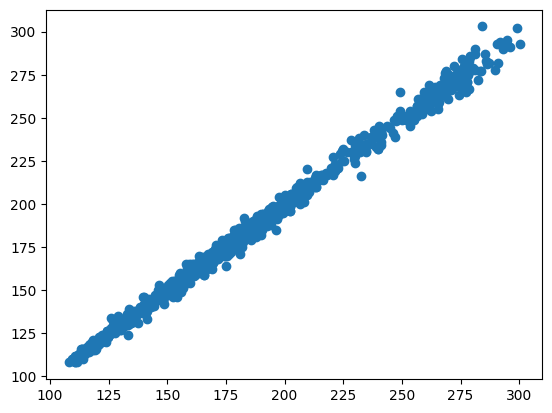

In [4]:
plt.scatter(df["Open"], df["Close"])

In [5]:

df.isna().any()

Open                  False
High                  False
Low                   False
Close                 False
Volume                False
Adj Close             False
Date                  False
before2017            False
between2017and2019    False
after2019             False
dtype: bool

In [6]:
df.dtypes

Open                  float64
High                  float64
Low                   float64
Close                   int64
Volume                  int64
Adj Close             float64
Date                   object
before2017              int64
between2017and2019      int64
after2019               int64
dtype: object

In [7]:
independent_vars_set = ["High", "Low", "Volume", "Adj Close", "Open", "before2017", "between2017and2019", "after2019"]

def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

df[independent_vars_set] = normalize(df[independent_vars_set])
df

,Open,High,Low,Close,Volume,Adj Close,Date,before2017,between2017and2019,after2019
0,0.027989,0.028866,0.035557,113,0.093464,0.025263,2016-03-28,1.0,0.0,0.0
1,0.030642,0.037705,0.039252,116,0.145209,0.037817,2016-03-29,1.0,0.0,0.0
2,0.045729,0.041128,0.043108,114,0.166032,0.030438,2016-03-30,1.0,0.0,0.0
3,0.035168,0.031012,0.039949,114,0.092583,0.027364,2016-03-31,1.0,0.0,0.0
4,0.030226,0.036939,0.037699,116,0.114280,0.037407,2016-04-01,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1255,0.949485,0.974659,0.966263,293,0.135730,0.946861,2021-03-22,0.0,0.0,1.0
1256,0.963531,0.965922,0.982650,290,0.103535,0.931950,2021-03-23,0.0,0.0,1.0
1257,0.952346,0.933837,0.936329,282,0.077118,0.888445,2021-03-24,0.0,0.0,1.0
1258,0.900219,0.915138,0.918068,278,0.112723,0.871022,2021-03-25,0.0,0.0,1.0


In [20]:
from sklearn.naive_bayes import MultinomialNB

dimension = len(independent_vars_set)

def split_between_x_y(df_local):
    return np.array(df_local[independent_vars_set]).reshape(-1, dimension), np.array(df_local["Close"])

train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

train_x, train_y = split_between_x_y(train)
valid_x, valid_y = split_between_x_y(validate)
test_x, test_y = split_between_x_y(test)

test_x.shape

(252, 8)

In [9]:
import optuna as opt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from abc import ABC, abstractmethod

class ModelRequest(ABC):
    @abstractmethod
    def acquire_hyper_params(hyper_params: list):
        pass

class KneighborsRequest(ModelRequest):
    def __init__(self, hyper_params: list):
        super().__init__()
        self.acquire_hyper_params(hyper_params)

    def acquire_hyper_params(self, hyper_params: list):
        self.k_neighbours = hyper_params[0]
        self.dist_neighbours = hyper_params[1]
        self.weights_neighbours = hyper_params[2]
        self.algorithm_neighbours = hyper_params[3]
    
class SVCRequest(ModelRequest):
    def __init__(self, hyper_params: list):
        super().__init__()
        self.acquire_hyper_params(hyper_params)

    def acquire_hyper_params(self, hyper_params: list):
        self.c_svm = hyper_params[0]
        self.kernel_svm = hyper_params[1]
        self.gamma_svm = hyper_params[2]
        self.degree_svm = hyper_params[3]

class BayesRequest(ModelRequest):
    def __init__(self, hyper_params: list):
        super().__init__()
        self.acquire_hyper_params(hyper_params)

    def acquire_hyper_params(self, hyper_params: list):
        self.alpha_bayes = hyper_params[0]
      

class DecisionTreeRequest(ModelRequest):
    def __init__(self, hyper_params: list):
        super().__init__()
        self.acquire_hyper_params(hyper_params)

    def acquire_hyper_params(self, hyper_params: list):
        self.criterion_trees = hyper_params[0]
        self.max_depth_trees = hyper_params[1]
        self.min_samples_split_trees = hyper_params[2]
        self.min_samples_leaf_trees = hyper_params[3]
        self.max_features_trees = hyper_params[4]

class LinearRegressionRequest(ModelRequest):
    def __init__(self, hyper_params: list):
        super().__init__()
        self.acquire_hyper_params(hyper_params)

    def acquire_hyper_params(self, hyper_params: list):
        self.n_jobs = hyper_params[0]       

class ModelWrapper:
    def __init__(self, model_request: ModelRequest):
        
        if isinstance(model_request, KneighborsRequest):
            self.model = KNeighborsClassifier(
                    n_neighbors=model_request.k_neighbours,
                    metric=model_request.dist_neighbours,
                    weights=model_request.weights_neighbours,
                    algorithm=model_request.algorithm_neighbours
                )
            
        elif isinstance(model_request, SVCRequest):
            self.model = SVC(C=model_request.c_svm, kernel=model_request.kernel_svm, gamma=model_request.gamma_svm,
                              degree=model_request.degree_svm)
        elif isinstance(model_request, BayesRequest):
            self.model = MultinomialNB(alpha=model_request.alpha_bayes)     
              
        elif isinstance(model_request, DecisionTreeRequest):
            self.model = DecisionTreeClassifier(criterion=model_request.criterion_trees, 
                                                max_depth=model_request.max_depth_trees, 
                                                min_samples_split=model_request.min_samples_split_trees,
                                                min_samples_leaf=model_request.min_samples_leaf_trees,
                                                max_features=model_request.max_features_trees
                                                )     
        elif isinstance(model_request, LinearRegressionRequest):
            self.model = LinearRegression(n_jobs=model_request.n_jobs)    

    def fit(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def predict(self, x_test):
        return self.model.predict(x_test)     
    
    def score(self, x_valid, y_valid):
        return self.model.score(x_valid, y_valid)

def objective(trial):
    model_type = trial.suggest_int("model_type", 1, 5)

    if model_type == 1:
        model_request = KneighborsRequest([
            trial.suggest_int("k_neighbours", 1, 399, 2),
            trial.suggest_categorical("dist_neighbours", ["minkowski", "euclidean", "manhattan"]),
            trial.suggest_categorical("weights_neighbours", ["uniform", "distance"]),
            trial.suggest_categorical("algorithm_neighbours", ["auto", "ball_tree", "kd_tree", "brute"])])

    elif model_type == 2:
        model_request = SVCRequest([
            trial.suggest_float("c_svm", 0.7, 1),
            trial.suggest_categorical("kernel_svm", ["linear", "poly", "rbf", "sigmoid"]),
            trial.suggest_categorical("gamma_svm", ["scale", "auto"]),
            trial.suggest_int("degree_svm", 1, 5)])

    elif model_type == 3:
         model_request = BayesRequest([ trial.suggest_float("alpha_bayes", 0.1, 1) ])

    elif model_type == 4:
         model_request = DecisionTreeRequest([
            trial.suggest_categorical("criterion_trees", ['entropy', 'gini']),
            trial.suggest_int("max_depth_trees", 1, 10),
            trial.suggest_int("min_samples_split_trees", 1, 20),
            trial.suggest_int("min_samples_leaf_trees", 4, 12),
            trial.suggest_categorical('suggest_categorical', ['auto', 'sqrt','log2'])])
    elif model_type == 5:
        model_request = LinearRegressionRequest([
            trial.suggest_int("n_jobs", 1, 20)
        ])     


    model = ModelWrapper(model_request)

    model.fit(train_x, train_y)

    return model.score(valid_x, valid_y)


def choose_your_fighter(params):
    model_type = params["model_type"]
    params.pop("model_type")

    values = list(params.values())
    if model_type == 1:
        best_model = ModelWrapper(KneighborsRequest(values))
    elif model_type == 2:
        best_model = ModelWrapper(SVCRequest(values))    
    elif model_type == 3:
        best_model = ModelWrapper(BayesRequest(values))
    elif model_type == 4:
        best_model = ModelWrapper(DecisionTreeRequest(values))
    elif model_type == 5:
        best_model = ModelWrapper(LinearRegressionRequest(values))    
    return best_model    


studyWithBaseSampler = opt.create_study(direction="minimize")
studyWithBaseSampler.optimize(objective, n_trials=100)

params = studyWithBaseSampler.best_params
print(params)
print(studyWithBaseSampler.best_value)

best_model = choose_your_fighter(params)
best_model.fit(train_x, train_y)
prediction = best_model.predict(test_x)


[I 2023-05-22 12:26:49,415] A new study created in memory with name: no-name-62a89c4a-ac58-4637-936d-48b2aeb7a54c
[I 2023-05-22 12:26:49,452] Trial 0 finished with value: 0.20238095238095238 and parameters: {'model_type': 4, 'criterion_trees': 'entropy', 'max_depth_trees': 6, 'min_samples_split_trees': 20, 'min_samples_leaf_trees': 11, 'suggest_categorical': 'log2'}. Best is trial 0 with value: 0.20238095238095238.
[I 2023-05-22 12:26:49,630] Trial 1 finished with value: 0.1746031746031746 and parameters: {'model_type': 1, 'k_neighbours': 269, 'dist_neighbours': 'minkowski', 'weights_neighbours': 'distance', 'algorithm_neighbours': 'brute'}. Best is trial 1 with value: 0.1746031746031746.
[I 2023-05-22 12:26:49,644] Trial 2 finished with value: 0.17857142857142858 and parameters: {'model_type': 4, 'criterion_trees': 'entropy', 'max_depth_trees': 9, 'min_samples_split_trees': 18, 'min_samples_leaf_trees': 9, 'suggest_categorical': 'sqrt'}. Best is trial 1 with value: 0.1746031746031746.

{'model_type': 2, 'c_svm': 0.907975839583622, 'kernel_svm': 'poly', 'gamma_svm': 'auto', 'degree_svm': 2}
0.003968253968253968


In [10]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(studyWithBaseSampler).show()

In [11]:
from optuna.visualization import plot_param_importances


plot_param_importances(studyWithBaseSampler, params=list(studyWithBaseSampler.best_params.keys())).show()

In [ ]:
# plt.figure(figsize=(20, 5))
# plt.plot(test_y, label="Real")
# plt.plot(prediction, label="Prediction")

# plt.grid(True)
# plt.axis('tight')
# plt.legend(loc = "best", fontsize = 18)
# plt.show()

In [ ]:
studyWithRandomSampler = opt.create_study(direction="minimize", sampler=opt.samplers.RandomSampler(), pruner=opt.pruners.MedianPruner())
studyWithRandomSampler.optimize(objective, n_trials = 100)
params = studyWithRandomSampler.best_params
print(params)
print(studyWithRandomSampler.best_value)

best_model = choose_your_fighter(params)
best_model.fit(train_x, train_y)
prediction = best_model.predict(test_x)

[I 2023-03-09 17:19:16,927] A new study created in memory with name: no-name-248b6a91-44a3-4c99-90a4-338357cf58f0
[I 2023-03-09 17:19:16,940] Trial 0 finished with value: 0.03571428571428571 and parameters: {'model_type': 3, 'alpha_bayes': 0.6307837456834718}. Best is trial 0 with value: 0.03571428571428571.
[I 2023-03-09 17:19:16,977] Trial 1 finished with value: 0.03571428571428571 and parameters: {'model_type': 1, 'k_neighbours': 247, 'dist_neighbours': 'manhattan', 'weights_neighbours': 'uniform', 'algorithm_neighbours': 'auto'}. Best is trial 0 with value: 0.03571428571428571.
[I 2023-03-09 17:19:17,005] Trial 2 finished with value: 0.03968253968253968 and parameters: {'model_type': 3, 'alpha_bayes': 0.4784615100390702}. Best is trial 0 with value: 0.03571428571428571.
[I 2023-03-09 17:19:17,012] Trial 3 finished with value: 0.999959479372073 and parameters: {'model_type': 5, 'n_jobs': 7}. Best is trial 0 with value: 0.03571428571428571.
[I 2023-03-09 17:19:17,021] Trial 4 finishe

{'model_type': 2, 'c_svm': 0.8840155698790331, 'kernel_svm': 'rbf', 'gamma_svm': 'auto', 'degree_svm': 2}
0.023809523809523808


In [ ]:
plot_optimization_history(studyWithRandomSampler).show()

In [ ]:
plot_param_importances(studyWithRandomSampler, params=list(studyWithRandomSampler.best_params.keys())).show()

In [ ]:
# plt.figure(figsize=(20, 5))
# plt.plot(test_y, label="Real")
# plt.plot(prediction, label="Prediction")

# plt.grid(True)
# plt.axis('tight')
# plt.legend(loc = "best", fontsize = 18)
# plt.show()